In [1]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [45]:
setwd("/ai/data/wuqiao/clinical_sample/WES/RAW_VCF/MT_analysis_2025.5.14_adjust_annotation/paired code and results_adjusted")

In [46]:
mutation=read.table("data/256sample_mutation_paired_clinical_filter.csv",sep=",",quote = "\"",header=T)

In [47]:
print(head(mutation))

       ID        Sample class  Chr Start   End Ref Alt Alt_all
1 1276016     KY-131795 tumor chrM 13262 13262   A   G       G
2 1276016     KY-131795 tumor chrM   530   530   C   T       T
3 1276016     KY-131795 tumor chrM   530   530   C   T       T
4 1276016     KY-131795 tumor chrM  8027  8027   G   A       A
5 1286797 KY-WES-137066 tumor chrM 11166 11166   G   A       A
6 1286797 KY-WES-137066 tumor chrM  2371  2371   T   C       C
             Mutation.Class Func.MT_ensGene Gene.MT_ensGene
1 Substitution (Transition)          exonic             ND5
2 Substitution (Transition)        upstream            RNR1
3 Substitution (Transition)        upstream        tRNA-Phe
4 Substitution (Transition)          exonic            COX2
5 Substitution (Transition)          exonic             ND4
6 Substitution (Transition)    ncRNA_exonic            RNR2
  ExonicFunc.MT_ensGene                        AAChange.MT_ensGene
1     nonsynonymous SNV  ND5:ENST00000361567:exon1:c.C925G:p.Q309E
2    

In [48]:
# 计算每个基因在每个样本中的突变数目
AF=unique(mutation[,c("Sample","class","Gene.MT_ensGene","AF_value")])

In [49]:
af_means <- AF %>%
filter(Gene.MT_ensGene != "missing") %>% 
  group_by(Sample, class,Gene.MT_ensGene) %>%
  summarise(Average_AF = mean(AF_value, na.rm = TRUE), .groups = "drop")

In [50]:
print(head(af_means))

# A tibble: 6 × 4
  Sample    class    Gene.MT_ensGene Average_AF
  <chr>     <chr>    <chr>                <dbl>
1 KY-131728 adjacent RNR1               0.00260
2 KY-131728 adjacent tRNA-Phe           0.00260
3 KY-131729 tumor    ND6                0.00134
4 KY-131732 adjacent CYTB               0.0962 
5 KY-131732 adjacent RNR1               0.133  
6 KY-131732 adjacent tRNA-Phe           0.133  


In [51]:
write.table(af_means,"data/AF of each gene in each sample_allgene.csv",sep=",",quote=F,row.names=F)

In [52]:
# 为每个基因在不同类别中计算平均突变数和95%置信区间
summary_stats <- af_means %>%
    group_by(Gene.MT_ensGene, class) %>%
    summarise(
        avg_count = mean(Average_AF),
        ci_lower = avg_count - 1.96 * sd(Average_AF) / sqrt(n()),
        ci_upper = avg_count + 1.96 * sd(Average_AF) / sqrt(n()),
        .groups = 'drop'
    )

In [53]:
# Step 3: 构建所有基因与 class 的组合，保留并集
gene_class_combinations <- expand.grid(
  Gene.MT_ensGene = unique(af_means$Gene.MT_ensGene[af_means$Gene.MT_ensGene != "missing"]),
  class = unique(af_means$class),
  stringsAsFactors = FALSE
)

# Step 4: 合并后缺失处为 NA
summary_stats_complete <- gene_class_combinations %>%
  left_join(summary_stats, by = c("Gene.MT_ensGene", "class"))

In [54]:
print(summary_stats_complete)

   Gene.MT_ensGene    class  avg_count      ci_lower   ci_upper
1             RNR1 adjacent 0.12128177  0.0744668898 0.16809665
2         tRNA-Phe adjacent 0.12682913  0.0783194463 0.17533882
3              ND6 adjacent 0.33409533 -0.3155520887 0.98374276
4             CYTB adjacent 0.13379273  0.0708115950 0.19677387
5         tRNA-Pro adjacent 0.14260343  0.0742705797 0.21093628
6         tRNA-Thr adjacent 0.14067459  0.0737496879 0.20759950
7              ND5 adjacent 0.27094838 -0.0006886611 0.54258541
8              ND2 adjacent 0.14929194  0.0343603310 0.26422354
9              ND3 adjacent 0.20634654 -0.1083271151 0.52102020
10        tRNA-Trp adjacent 0.01584713  0.0021182926 0.02957596
11        tRNA-Val adjacent         NA            NA         NA
12             ND1 adjacent 0.31125000 -0.1180693287 0.74056933
13             ND4 adjacent 0.28337500 -0.0323430628 0.59909306
14       tRNA-Leu2 adjacent         NA            NA         NA
15            COX2 adjacent 0.53875000 -

In [55]:
write.table(summary_stats_complete,"data/average AF of each gene in each sample_allgene.csv",sep=",",quote=F,row.names=F)

In [56]:
# 分别绘制 adjacent 类别的分布图
adjacent_stats <- summary_stats_complete %>% filter(class == "adjacent")

# 按照 avg_count 从大到小排序
adjacent_stats <- adjacent_stats %>%
    arrange(desc(avg_count)) %>%
    mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = Gene.MT_ensGene))

In [57]:
print(adjacent_stats)

   Gene.MT_ensGene    class  avg_count      ci_lower   ci_upper
1             ATP6 adjacent 0.77300000  0.5460261838 0.99997382
2             COX2 adjacent 0.53875000 -0.3643200000 1.44182000
3        tRNA-Ser1 adjacent 0.53850000 -0.3640800000 1.44108000
4         tRNA-Asp adjacent 0.53850000 -0.3640800000 1.44108000
5         tRNA-Lys adjacent 0.53850000 -0.3640800000 1.44108000
6             RNR2 adjacent 0.48190900  0.1151492547 0.84866875
7             ATP8 adjacent 0.37933333 -0.2280161706 0.98668284
8              ND6 adjacent 0.33409533 -0.3155520887 0.98374276
9              ND1 adjacent 0.31125000 -0.1180693287 0.74056933
10             ND4 adjacent 0.28337500 -0.0323430628 0.59909306
11             ND5 adjacent 0.27094838 -0.0006886611 0.54258541
12            COX3 adjacent 0.22412183 -0.0809365016 0.52918017
13            COX1 adjacent 0.21113929 -0.0446402172 0.46691880
14             ND3 adjacent 0.20634654 -0.1083271151 0.52102020
15             ND2 adjacent 0.14929194  

In [59]:
# 处理 tumor 类别的图
tumor_stats <- summary_stats_complete %>% filter(class == "tumor")

# 确保基因的顺序与 tumor 一致
tumor_stats <- tumor_stats %>%
    mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = levels(adjacent_stats$Gene.MT_ensGene)))

In [60]:
print(tumor_stats)

   Gene.MT_ensGene class avg_count     ci_lower  ci_upper
1             RNR1 tumor 0.1428305  0.080675606 0.2049854
2         tRNA-Phe tumor 0.1344928  0.070901564 0.1980840
3              ND6 tumor 0.3021433 -0.072604617 0.6768913
4             CYTB tumor 0.1978761  0.140933823 0.2548185
5         tRNA-Pro tumor 0.2039071  0.135024145 0.2727901
6         tRNA-Thr tumor 0.2117920  0.142681249 0.2809027
7              ND5 tumor 0.4418222  0.338451642 0.5451927
8              ND2 tumor 0.6203279  0.414021615 0.8266343
9              ND3 tumor 0.2542188  0.026380274 0.4820573
10        tRNA-Trp tumor 0.4329368 -0.029225320 0.8950988
11        tRNA-Val tumor 0.0620000           NA        NA
12             ND1 tumor 0.3423412  0.200522136 0.4841602
13             ND4 tumor 0.4024759  0.252838531 0.5521133
14       tRNA-Leu2 tumor 0.1050000           NA        NA
15            COX2 tumor 0.2958642  0.101166647 0.4905618
16            ATP6 tumor 0.7067350  0.459375379 0.9540947
17            

In [61]:
# 计算全局的颜色范围和 X 轴范围
color_limits <- range(c(adjacent_stats$avg_count, tumor_stats$avg_count), na.rm = TRUE)
x_limits <- c(-0.37, 1.5)

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


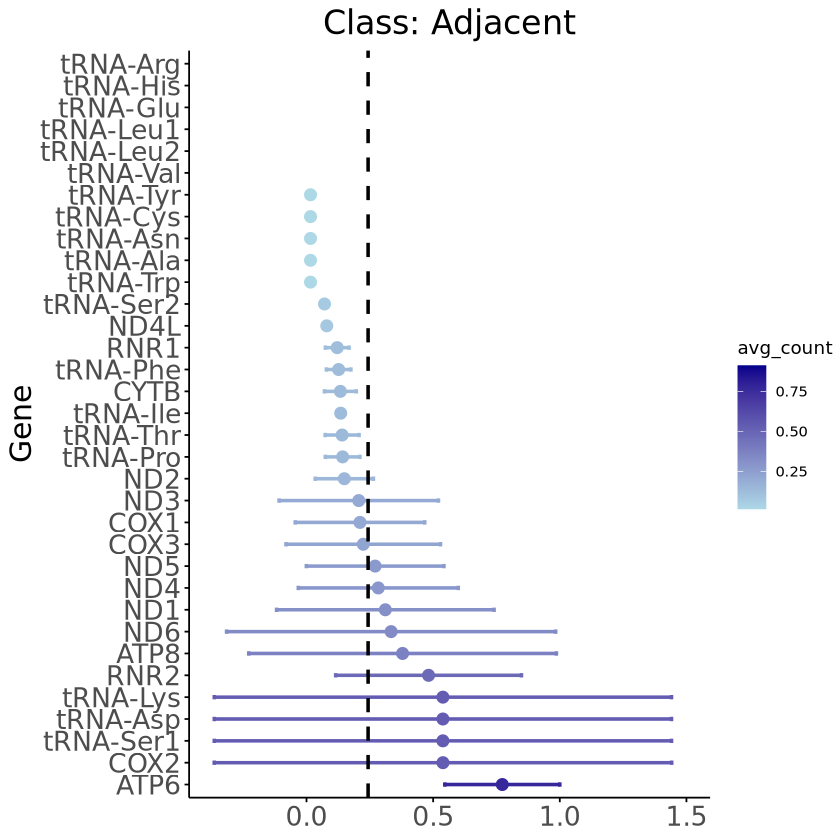

In [62]:
mean_avg_count <- mean(adjacent_stats$avg_count, na.rm = TRUE)
adjacent_plot <- ggplot(adjacent_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Adjacent") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) +  # 不再需要 limits，使用默认
    scale_x_continuous(limits = x_limits) +  # 设置 X 轴范围
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  # 去掉 X 轴标题

print(adjacent_plot)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


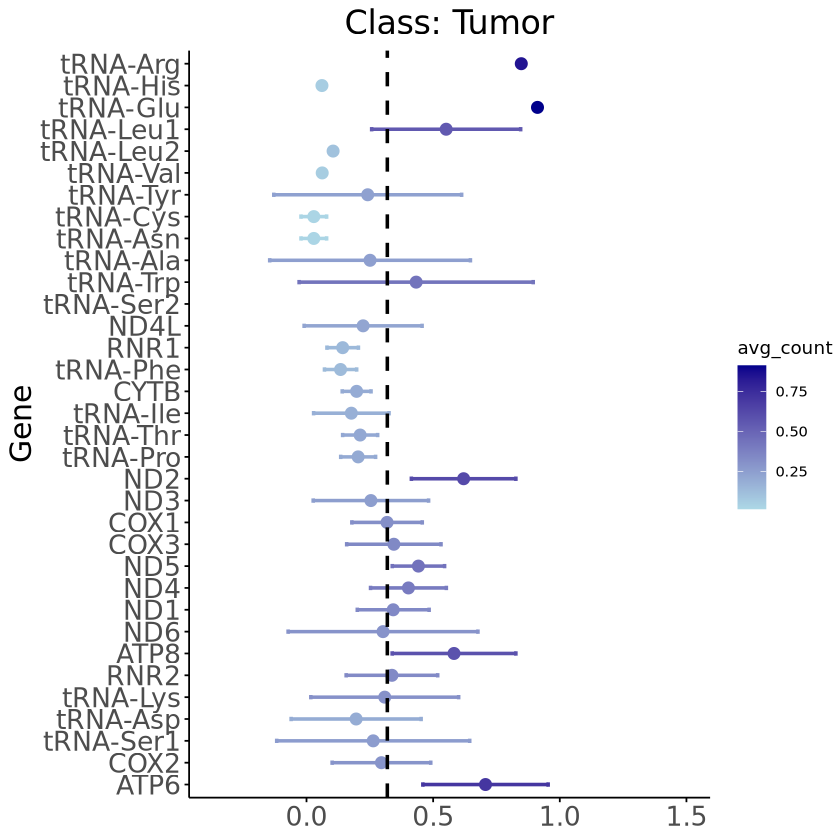

In [63]:
mean_avg_count <- mean(tumor_stats$avg_count, na.rm = TRUE)
# 创建 tumor_plot
tumor_plot <- ggplot(tumor_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Tumor") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) +  # 不再需要 limits，使用默认
    scale_x_continuous(limits = x_limits) +  # 设置 X 轴范围
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  # 去掉 X 轴标题

print(tumor_plot)

In [65]:
library(patchwork)

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


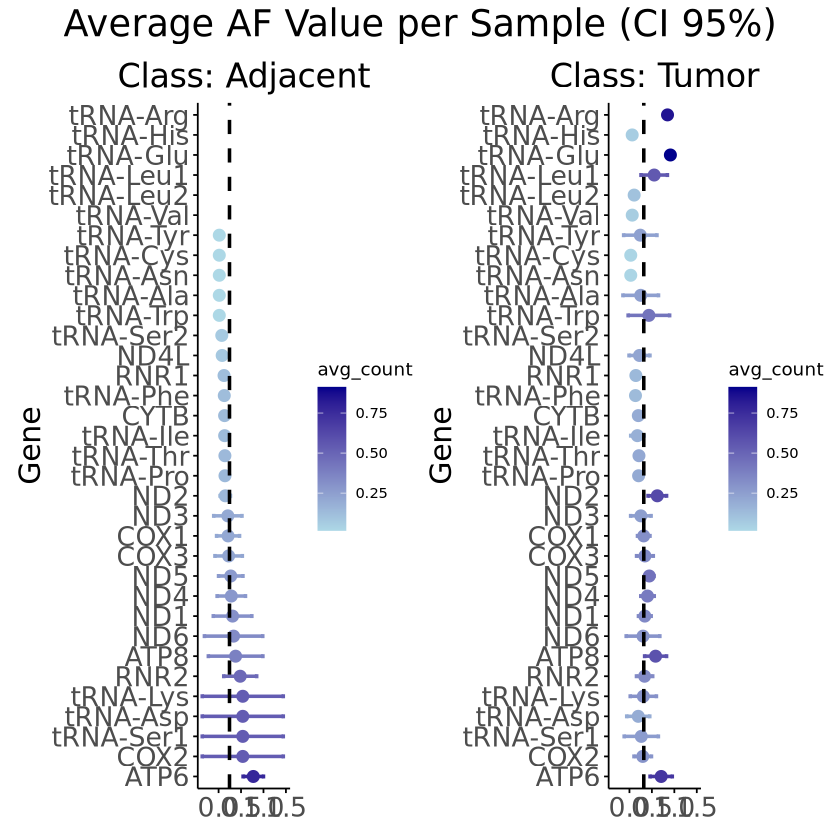

In [66]:

# 将两个图拼在一起，设置为一行
combined_plot <-  adjacent_plot + tumor_plot + plot_layout(ncol = 2) +
    plot_annotation(title = "Average AF Value per Sample (CI 95%)", 
                    theme = theme(plot.title = element_text(size = 22, hjust = 0.5)))

print(combined_plot)

In [67]:
ggsave("plots/AF value of per gene in per sample all gene.pdf", plot = combined_plot, width = 12, height = 9,dpi=300)

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
